# Install Libraries

In [154]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os



# Modeling

In [155]:
X_train = pd.read_parquet('/Users/emiliodulay/Documents/1. UCLA/MATH 156/data/X_train_baseline.parquet.parquet')
X_test  = pd.read_parquet('/Users/emiliodulay/Documents/1. UCLA/MATH 156/data/X_test_baseline.parquet.parquet')
y_train = pd.read_parquet('/Users/emiliodulay/Documents/1. UCLA/MATH 156/data/y_train.parquet.parquet')

In [156]:
numeric_features = ['distance', 'passenger_count', 'pickup_hour', 'pickup_dayofweek', 'is_rest_day']
categorical_features = ['vendor_id', 'store_and_fwd_flag']

In [157]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
])

X_train_processed = preprocessor.fit_transform(X_train)

In [158]:
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.squeeze(), dtype=torch.float32)  # regression

In [159]:
def to_tensor(x) :
    
    numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
    
    
    preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

    x_processed = preprocessor.fit_transform(x)
    x_tensor = torch.tensor(x_processed, dtype=torch.float32)
    return x_tensor


In [160]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_train_tensor, y_train_tensor)


In [161]:
def rmsle(y_true, y_pred):
    """
    Computes Root Mean Squared Logarithmic Error
    y_true and y_pred should be non-negative
    """
    # Ensure predictions are >= 0 to avoid log issues
    y_pred = np.maximum(y_pred, 0)
    y_true = np.maximum(y_true, 0)
    
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))


# FFNN

## Baseline Model

In [162]:
class FFNN_simple(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, output_size)
        )

    def forward(self, x):
        return self.net(x)


In [163]:
class FFNN_complex(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, output_size)
        )

    def forward(self, x):
        return self.net(x)


In [164]:
## 2 Hidden Layer FFNN ##
model = FFNN_simple(input_size=X_train_tensor.shape[1], output_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
all_epochs_results = []

for epoch in range(5):
    total_loss = 0
    all_preds = []
    all_targets = []

    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        all_preds.append(preds.detach().numpy())
        all_targets.append(yb.detach().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    rmsle_val = rmsle(all_targets, all_preds)  # <-- added RMSLE

    epoch_results = {
        "epoch": epoch + 1,
        "loss": total_loss / len(loader),
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "RMSLE": rmsle_val
    }
    
    all_epochs_results.append(epoch_results)

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(loader):.4f} | "
          f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | "
          f"R²: {r2:.4f} | RMSLE: {rmsle_val:.4f}")

baseline_two_layer_results = all_epochs_results

## 4 Hidden Layer FFNN ## 
model = FFNN_complex(input_size=X_train_tensor.shape[1], output_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
all_epochs_results = []

for epoch in range(5):
    total_loss = 0
    all_preds = []
    all_targets = []

    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        all_preds.append(preds.detach().numpy())
        all_targets.append(yb.detach().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    rmsle_val = rmsle(all_targets, all_preds)  # <-- added RMSLE

    epoch_results = {
        "epoch": epoch + 1,
        "loss": total_loss / len(loader),
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "RMSLE": rmsle_val
    }
    
    all_epochs_results.append(epoch_results)

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(loader):.4f} | "
          f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | "
          f"R²: {r2:.4f} | RMSLE: {rmsle_val:.4f}")
    
baseline_four_layer_results = all_epochs_results


Epoch 1 | Loss: 27194952.5372 | MSE: 27195178.0000 | RMSE: 5214.8996 | MAE: 465.6486 | R²: 0.0086 | RMSLE: 0.8127
Epoch 2 | Loss: 27153413.6025 | MSE: 27153636.0000 | RMSE: 5210.9151 | MAE: 441.8488 | R²: 0.0101 | RMSLE: 0.6267
Epoch 3 | Loss: 27143293.0727 | MSE: 27143516.0000 | RMSE: 5209.9440 | MAE: 438.7777 | R²: 0.0105 | RMSLE: 0.6104
Epoch 4 | Loss: 27139118.2700 | MSE: 27139342.0000 | RMSE: 5209.5434 | MAE: 437.8586 | R²: 0.0106 | RMSLE: 0.6026
Epoch 5 | Loss: 27139996.2631 | MSE: 27140218.0000 | RMSE: 5209.6274 | MAE: 436.4459 | R²: 0.0106 | RMSLE: 0.5987
Epoch 1 | Loss: 27176007.1997 | MSE: 27176228.0000 | RMSE: 5213.0824 | MAE: 460.5498 | R²: 0.0093 | RMSLE: 0.7270
Epoch 2 | Loss: 27149081.3593 | MSE: 27149302.0000 | RMSE: 5210.4992 | MAE: 443.6960 | R²: 0.0103 | RMSLE: 0.6241
Epoch 3 | Loss: 27146392.7827 | MSE: 27146616.0000 | RMSE: 5210.2415 | MAE: 441.0592 | R²: 0.0104 | RMSLE: 0.6144
Epoch 4 | Loss: 27145464.7199 | MSE: 27145686.0000 | RMSE: 5210.1522 | MAE: 441.2969 | R

## Adv FE Modeling

In [165]:
X_train_adv = pd.read_parquet('/Users/emiliodulay/Documents/1. UCLA/MATH 156/data/X_train_advanced_smaller.parquet.parquet')

In [166]:
# sample given advanced fe too large  
X_train_sample = X_train_adv.sample(500_000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]
# drop non numeric 
X_train_adv_samp = X_train_sample.drop(columns=["id", "trip_duration", "pickup_datetime", "dropoff_datetime"])

# create numeric and cat list 
numeric_features = X_train_adv_samp.select_dtypes(include=["int64", "int32", "float64"]).columns.tolist()
categorical_features = X_train_adv_samp.select_dtypes(include=["object", "category"]).columns.tolist()

In [167]:
X_train_adv_tensor = to_tensor(X_train_adv_samp)
y_train_adv_tensor = torch.tensor(y_train_sample.values.squeeze(), dtype=torch.float32)

In [168]:
# ADV datset
train_adv_dataset = MyDataset(X_train_adv_tensor, y_train_adv_tensor)

In [171]:
## two hidden layer ##
model = FFNN_simple(input_size=X_train_adv_tensor.shape[1], output_size=1)  # regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

loader = DataLoader(train_adv_dataset, batch_size=32, shuffle=True)

all_epochs_results = []  # list to store each epoch's results

for epoch in range(5):
    total_loss = 0
    all_preds = []
    all_targets = []

    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        all_preds.append(preds.detach().numpy())
        all_targets.append(yb.detach().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    rmsle_val = rmsle(all_targets, all_preds)  # <-- added RMSLE
    
    # Store results for this epoch
    epoch_results = {
        "epoch": epoch + 1,
        "loss": total_loss / len(loader),
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "RMSLE" : rmsle_val
    }
    all_epochs_results.append(epoch_results)

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(loader):.4f} | "
          f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

feature_engineer_two_layer_results = all_epochs_results

## four hidden layer ##
model = FFNN_complex(input_size=X_train_adv_tensor.shape[1], output_size=1)  # regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

loader = DataLoader(train_adv_dataset, batch_size=32, shuffle=True)

all_epochs_results = []  # list to store each epoch's results

for epoch in range(5):
    total_loss = 0
    all_preds = []
    all_targets = []

    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        all_preds.append(preds.detach().numpy())
        all_targets.append(yb.detach().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    rmsle_val = rmsle(all_targets, all_preds)  # <-- added RMSLE
    
    # Store results for this epoch
    epoch_results = {
        "epoch": epoch + 1,
        "loss": total_loss / len(loader),
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "RMSLE" : rmsle_val
    }
    all_epochs_results.append(epoch_results)

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(loader):.4f} | "
          f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

feature_engineer_four_layer_results = all_epochs_results

Epoch 1 | Loss: 10003198.3261 | MSE: 10003199.0000 | RMSE: 3162.7834 | MAE: 488.3702 | R²: 0.0050
Epoch 2 | Loss: 9842038.7242 | MSE: 9842039.0000 | RMSE: 3137.2024 | MAE: 439.8573 | R²: 0.0210
Epoch 3 | Loss: 9809294.0099 | MSE: 9809294.0000 | RMSE: 3131.9792 | MAE: 427.5094 | R²: 0.0242
Epoch 4 | Loss: 9794701.8622 | MSE: 9794701.0000 | RMSE: 3129.6487 | MAE: 421.5830 | R²: 0.0257
Epoch 5 | Loss: 9783209.7392 | MSE: 9783210.0000 | RMSE: 3127.8123 | MAE: 415.8439 | R²: 0.0268
Epoch 1 | Loss: 9866848.5967 | MSE: 9866849.0000 | RMSE: 3141.1541 | MAE: 448.8921 | R²: 0.0185
Epoch 2 | Loss: 9808527.4940 | MSE: 9808528.0000 | RMSE: 3131.8570 | MAE: 436.0235 | R²: 0.0243
Epoch 3 | Loss: 9793592.6329 | MSE: 9793593.0000 | RMSE: 3129.4717 | MAE: 438.1955 | R²: 0.0258
Epoch 4 | Loss: 9777000.9983 | MSE: 9777000.0000 | RMSE: 3126.8195 | MAE: 426.2746 | R²: 0.0275
Epoch 5 | Loss: 9758836.5071 | MSE: 9758837.0000 | RMSE: 3123.9137 | MAE: 418.5718 | R²: 0.0293


### Model Performance Plots

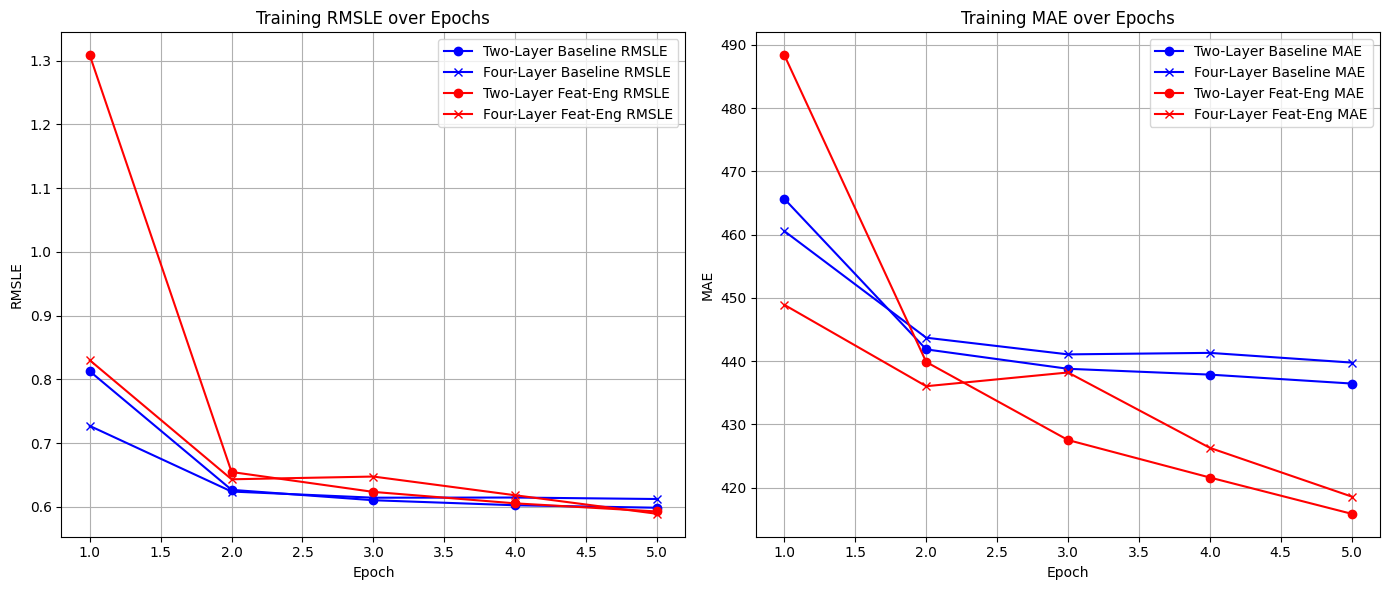

In [172]:
import matplotlib.pyplot as plt

epochs = [e["epoch"] for e in baseline_two_layer_results]

# Extract metrics from baseline_results (2 layer)
rmsle_baseline_two_layer = [e["RMSLE"] for e in baseline_two_layer_results]
mae_baseline_two_layer = [e["MAE"] for e in baseline_two_layer_results]

# Extract metrics from baseline_results (4 layer)
rmsle_baseline_four_layer = [e["RMSLE"] for e in baseline_four_layer_results]
mae_baseline_four_layer = [e["MAE"] for e in baseline_four_layer_results]

# Extract metrics from feature_engineer_results (2 layer)
rmsle_feat_two_layer = [e["RMSLE"] for e in feature_engineer_two_layer_results]
mae_feat_two_layer = [e["MAE"] for e in feature_engineer_two_layer_results]

# Extract metrics from feature_engineer_results (2 layer)
rmsle_feat_four_layer = [e["RMSLE"] for e in feature_engineer_four_layer_results]
mae_feat_four_layer = [e["MAE"] for e in feature_engineer_four_layer_results]

# Create a figure with multiple subplots
plt.figure(figsize=(14, 6))

# Subplot 1: RMSLE
plt.subplot(1, 2, 1)
plt.plot(epochs, rmsle_baseline_two_layer, marker='o', color='blue', label='Two-Layer Baseline RMSLE')
plt.plot(epochs, rmsle_baseline_four_layer, marker='x', color='blue', label='Four-Layer Baseline RMSLE')
plt.plot(epochs, rmsle_feat_two_layer, marker = 'o', color = "red", label = "Two-Layer Feat-Eng RMSLE")
plt.plot(epochs, rmsle_feat_four_layer, marker = 'x', color = "red", label = "Four-Layer Feat-Eng RMSLE")
plt.xlabel('Epoch')
plt.ylabel('RMSLE')
plt.title('Training RMSLE over Epochs')
plt.grid(True)
plt.legend()

# Subplot 2: RMSE, MAE, R²
plt.subplot(1, 2, 2)
plt.plot(epochs, mae_baseline_two_layer, marker='o', color='blue', label='Two-Layer Baseline MAE')
plt.plot(epochs, mae_baseline_four_layer, marker='x', color='blue', label='Four-Layer Baseline MAE')
plt.plot(epochs, mae_feat_two_layer, marker = 'o', color = "red", label = "Two-Layer Feat-Eng MAE")
plt.plot(epochs, mae_feat_four_layer, marker = 'x', color = "red", label = "Four-Layer Feat-Eng MAE")
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training MAE over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Combo Feature Modeling

In [173]:
feature_combinations = {
     "combo_A": [
         'euclid_dist',
         'dir_sin', 'dir_cos',
         'hour', 'weekday',
         'center_cluster_avg_speed',
         'passenger_count',
         'vendor_id'
     ],

    "combo_B": [
        'rot_ns_dist', 'rot_ew_dist',
        'direction_angle',
        'week_hour',
        'pu_cluster_avg_speed', 'do_cluster_avg_speed',
        'passenger_count'
    ],

     "combo_C": [
         'manhattan_dist',
         'dir_bin4',
         'is_rest_day',
         'center_cluster',
         'vendor_id'
     ],

     "combo_D": [
         'distance',
         'dir_bin4',
         'hour_avg_speed',
         'center_cluster',
         'passenger_count'
     ],

    "combo_E": [
        'distance',
        'dir_sin', 'dir_cos',
        'week_hour',
        'center_cluster_avg_speed',
        'pu_cluster_avg_speed',
        'store_and_fwd_flag',
        'passenger_count'
    ],

    "combo_F": [
        'rot_ns_dist', 
        'rot_ew_dist', 
        'pu_cluster_avg_speed', 
        'do_cluster_avg_speed', 
        'passenger_count'
    ]
}

In [174]:
all_results = {}
target = 'trip_duration'

In [175]:
def load_combo(filename, feature_combinations, data_dir="/Users/emiliodulay/Documents/1. UCLA/MATH 156/data"):
    """
    Load a parquet file for a given feature combination and return only the relevant columns.

    Parameters:
    - filename (str): e.g., "combo_A.parquet"
    - feature_combinations (dict): maps combo names to feature lists
    - data_dir (str): folder where parquet files are stored

    Returns:
    - pandas DataFrame with only the specified features
    """
    # Extract combo name (e.g., "combo_A" from "combo_A.parquet")
    combo_name = os.path.splitext(os.path.basename(filename.split(".")[0]))[0]

    if combo_name not in feature_combinations:
        raise ValueError(f"Combo '{combo_name}' not found in feature_combinations.")

    # Load the parquet file
    filepath = os.path.join(data_dir, filename)
    df = pd.read_parquet(filepath)

    # Select only the features specified for this combo
    features = feature_combinations[combo_name]
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        raise ValueError(f"Missing features in file {filename}: {missing_features}")

    return df[features]


### Two-Layer Combination Performance

In [ ]:
all_results = {}

for combo_name, features in feature_combinations.items():
    print(f"\n=== Running combination: {combo_name} ===")

    df = X_train_adv
    X = df[features].copy()
    y = y_train

    X_tensor = to_tensor(X)
    y_tensor = torch.tensor(y.values.squeeze(), dtype=torch.float32)
    
    train_adv_dataset = MyDataset(X_tensor, y_tensor)
    
    numeric_features = X.select_dtypes(include=["int64", "int32", "float64"]).columns.tolist()
    categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
    
    model = FFNN_simple(input_size=X_tensor.shape[1], output_size=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    loader = DataLoader(train_adv_dataset, batch_size=32, shuffle=True)

    # Initialize a list to store all epoch results for this combo
    all_results[combo_name] = []

    for epoch in range(5):
        total_loss = 0
        all_preds = []
        all_targets = []

        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb).squeeze()
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            all_preds.append(preds.detach().numpy())
            all_targets.append(yb.detach().numpy())

        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)

        mse = mean_squared_error(all_targets, all_preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(all_targets, all_preds)
        r2 = r2_score(all_targets, all_preds)
        rmsle_val = rmsle(all_targets, all_preds)  # <-- added RMSLE

        combo_results = {
            "epoch": epoch + 1,
            "loss": total_loss / len(loader),
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2,
            "RMSLE" : rmsle_val
        }

        # Append this epoch's results to the list
        all_results[combo_name].append(combo_results)
        
combo_two_layer_results = all_results




=== Running combination: combo_A ===

=== Running combination: combo_B ===

=== Running combination: combo_C ===

=== Running combination: combo_D ===

=== Running combination: combo_E ===

=== Running combination: combo_F ===


In [ ]:
for combo_name, epochs in combo_two_layer_results.items():
    print(f"\n=== Results for {combo_name} ===")
    for epoch_result in epochs:
        print(f"Epoch {epoch_result['epoch']}: "
              f"Loss={epoch_result['loss']:.4f}, "
              f"MSE={epoch_result['MSE']:.4f}, "
              f"RMSE={epoch_result['RMSE']:.4f}, "
              f"MAE={epoch_result['MAE']:.4f}, "
              f"R²={epoch_result['R2']:.4f}")

### Four Layer Combination Performance

In [ ]:
all_results = {}

for combo_name, features in feature_combinations.items():
    print(f"\n=== Running combination: {combo_name} ===")

    df = X_train_adv
    X = df[features].copy()
    y = y_train

    X_tensor = to_tensor(X)
    y_tensor = torch.tensor(y.values.squeeze(), dtype=torch.float32)
    
    train_adv_dataset = MyDataset(X_tensor, y_tensor)
    
    numeric_features = X.select_dtypes(include=["int64", "int32", "float64"]).columns.tolist()
    categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
    
    model = FFNN_simple(input_size=X_tensor.shape[1], output_size=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    loader = DataLoader(train_adv_dataset, batch_size=32, shuffle=True)

    # Initialize a list to store all epoch results for this combo
    all_results[combo_name] = []

    for epoch in range(5):
        total_loss = 0
        all_preds = []
        all_targets = []

        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb).squeeze()
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            all_preds.append(preds.detach().numpy())
            all_targets.append(yb.detach().numpy())

        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)

        mse = mean_squared_error(all_targets, all_preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(all_targets, all_preds)
        r2 = r2_score(all_targets, all_preds)
        rmsle_val = rmsle(all_targets, all_preds)  # <-- added RMSLE

        combo_results = {
            "epoch": epoch + 1,
            "loss": total_loss / len(loader),
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2,
            "RMSLE" : rmsle_val
        }

        # Append this epoch's results to the list
        all_results[combo_name].append(combo_results)
        
combo_four_layer_results = all_results


/Users/emiliodulay/Documents/1. UCLA/MATH 156/data/combo_A.parquet.parquet

In [ ]:
for combo_name, epochs in combo_four_layer_results.items():
    print(f"\n=== Results for {combo_name} ===")
    for epoch_result in epochs:
        print(f"Epoch {epoch_result['epoch']}: "
              f"Loss={epoch_result['loss']:.4f}, "
              f"MSE={epoch_result['MSE']:.4f}, "
              f"RMSE={epoch_result['RMSE']:.4f}, "
              f"MAE={epoch_result['MAE']:.4f}, "
              f"R²={epoch_result['R2']:.4f}")



=== Results for combo_A ===
Epoch 1: Loss=27178077.5315, MSE=27178298.0000, RMSE=5213.2809, MAE=452.1286, R²=0.0092
Epoch 2: Loss=27137754.6862, MSE=27137976.0000, RMSE=5209.4123, MAE=435.0757, R²=0.0107
Epoch 3: Loss=27131095.7539, MSE=27131320.0000, RMSE=5208.7734, MAE=433.2311, R²=0.0109
Epoch 4: Loss=27127702.7574, MSE=27127926.0000, RMSE=5208.4476, MAE=433.1429, R²=0.0110
Epoch 5: Loss=27124317.5715, MSE=27124538.0000, RMSE=5208.1223, MAE=433.0854, R²=0.0112

=== Results for combo_B ===
Epoch 1: Loss=27170232.8345, MSE=27170454.0000, RMSE=5212.5286, MAE=439.2173, R²=0.0095
Epoch 2: Loss=27137025.7776, MSE=27134270.0000, RMSE=5209.0565, MAE=425.4976, R²=0.0108
Epoch 3: Loss=27127252.2810, MSE=27124630.0000, RMSE=5208.1311, MAE=424.0509, R²=0.0112
Epoch 4: Loss=27120434.0530, MSE=27120654.0000, RMSE=5207.7494, MAE=423.7160, R²=0.0113
Epoch 5: Loss=27119049.3536, MSE=27119270.0000, RMSE=5207.6165, MAE=422.9835, R²=0.0114

=== Results for combo_C ===
Epoch 1: Loss=27179367.7289, MSE=

In [185]:
for combo_name, epochs in combo_two_layer_results.items():
    epoch_nums = [e['epoch'] for e in epochs]
    print(combo_name)
    print(epoch_nums)
    print(epochs)



combo_A
[1, 2, 3, 4, 5]
[{'epoch': 1, 'loss': 27212301.759909123, 'MSE': 27212522.0, 'RMSE': np.float64(5216.562277975793), 'MAE': 474.97625732421875, 'R2': 0.007952690124511719}, {'epoch': 2, 'loss': 27179628.658880845, 'MSE': 27179852.0, 'RMSE': np.float64(5213.429965003846), 'MAE': 453.15625, 'R2': 0.0091438889503479}, {'epoch': 3, 'loss': 27176034.162072826, 'MSE': 27176258.0, 'RMSE': np.float64(5213.085266902893), 'MAE': 453.4324951171875, 'R2': 0.009274780750274658}, {'epoch': 4, 'loss': 27174193.216717478, 'MSE': 27174414.0, 'RMSE': np.float64(5212.908401266994), 'MAE': 452.68792724609375, 'R2': 0.009342074394226074}, {'epoch': 5, 'loss': 27174172.32455219, 'MSE': 27174394.0, 'RMSE': np.float64(5212.906482951713), 'MAE': 451.4891357421875, 'R2': 0.009342849254608154}]
combo_B
[1, 2, 3, 4, 5]
[{'epoch': 1, 'loss': 27303907.66314359, 'MSE': 27304132.0, 'RMSE': np.float64(5225.335587309201), 'MAE': 493.9837341308594, 'R2': 0.004613041877746582}, {'epoch': 2, 'loss': 27160054.130165

KeyError: 'RMSLE'

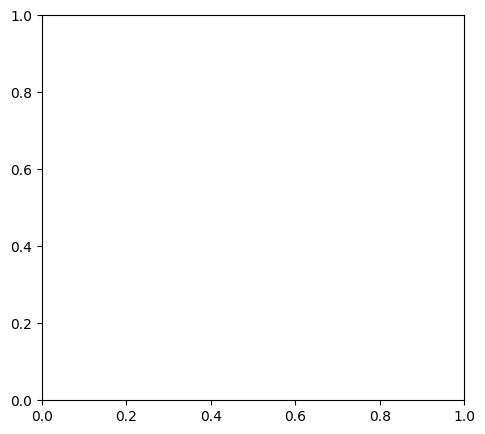

In [177]:
import matplotlib.pyplot as plt

# Plot Loss and R² over epochs for all combos
plt.figure(figsize=(12, 5))

# Subplot 1: RMSLE
plt.subplot(1, 2, 1)
for combo_name, epochs in combo_two_layer_results.items():
    epoch_nums = [e['epoch'] for e in epochs]
    rmsle_two_layer_combo = [e['RMSLE'] for e in epochs]
    plt.plot(epoch_nums, rmsle_two_layer_combo, marker='o', label=combo_name)
for combo_name, epochs in combo_four_layer_results.items():
    epoch_nums = [e['epoch'] for e in epochs]
    RMSLE_four_layer_combo = [e['RMSLE'] for e in epochs]
    plt.plot(epoch_nums, RMSLE_four_layer_combo, marker='x', label=combo_name)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training RMSLE per Combo")
plt.legend()
plt.grid(True)

# Subplot 2: MAE
for combo_name, epochs in combo_two_layer_results.items():
    epoch_nums = [e['epoch'] for e in epochs]
    MAE_two_layer_combo = [e['MAE'] for e in epochs]
    plt.plot(epoch_nums, MAE_two_layer_combo, marker='o', label=combo_name)
for combo_name, epochs in combo_four_layer_results.items():
    epoch_nums = [e['epoch'] for e in epochs]
    MAE_four_layer_combo = [e['MAE'] for e in epochs]
    plt.plot(epoch_nums, MAE_four_layer_combo, marker='x', label=combo_name)
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training MAE per Combo")
plt.legend()
plt.grid(True)
    
plt.tight_layout()
plt.show()
